In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

## 1) Coletando dados ficticios

In [2]:
# Especifique o caminho para o arquivo CSV
caminho_arquivo_csv = "../Dados/alunos_vet_ficticios.csv"

# Carregue o arquivo CSV em um DataFrame
df = pd.read_csv(caminho_arquivo_csv)

df

,Media_Total,Coeficiente,Introducao_a_Programacao,Estrutura_de_Dados,Introducao_a_Programacao_Aprovado,Estrutura_de_Dados_Aprovado,Desempenho
0,9.626715,10.644896,3.088811,1.762699,0,0,Bem
1,9.960334,9.818715,4.464785,7.720980,0,1,Bem
2,8.740338,9.086914,2.740052,0.712933,0,0,Bem
3,7.774918,7.093310,0.930765,4.508544,0,0,Bem
4,5.637035,4.517239,6.393895,2.023240,1,0,Mal
...,...,...,...,...,...,...,...
995,7.914746,9.330353,0.823461,4.628386,0,0,Bem
996,7.816127,7.221967,2.966806,1.612926,0,0,Bem
997,7.139751,6.000495,0.525839,8.293730,0,1,Médio
998,8.311339,8.480750,8.148992,3.742535,1,0,Bem


### 1.1) Dividir os dados em recursos (X) e rótulos (y)

In [3]:
X = df[['Media_Total', 'Coeficiente', 'Introducao_a_Programacao', 'Estrutura_de_Dados']]
y = df['Desempenho']

## 2) Pré-processando dados

In [4]:
# Codificar as classes de desempenho em valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## 3) Divisão em dados de treinamento e teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizar as características (normalização)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converter as classes em vetores one-hot (para a camada de saída)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## 4) Construindo rede neural

In [6]:
# Construir um modelo de rede neural
neuralNetwork = Sequential()
neuralNetwork.add(Dense(64, input_dim=4, activation='relu'))
neuralNetwork.add(Dense(32, activation='relu'))
neuralNetwork.add(Dense(3, activation='softmax'))  # 3 unidades na camada de saída para as três classes

## 5) Compilando Modelo

In [7]:
neuralNetwork.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 6) Treinando Modelo

In [8]:
neuralNetwork.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
25/25 [==============================] - 1s 958us/step - loss: 0.9094 - accuracy: 0.6275
Epoch 2/50
25/25 [==============================] - 0s 833us/step - loss: 0.6333 - accuracy: 0.7738
Epoch 3/50
25/25 [==============================] - 0s 833us/step - loss: 0.4889 - accuracy: 0.8125
Epoch 4/50
25/25 [==============================] - 0s 833us/step - loss: 0.3985 - accuracy: 0.8763
Epoch 5/50
25/25 [==============================] - 0s 750us/step - loss: 0.3396 - accuracy: 0.8838
Epoch 6/50
25/25 [==============================] - 0s 792us/step - loss: 0.2954 - accuracy: 0.9013
Epoch 7/50
25/25 [==============================] - 0s 792us/step - loss: 0.2615 - accuracy: 0.9062
Epoch 8/50
25/25 [==============================] - 0s 792us/step - loss: 0.2350 - accuracy: 0.9137
Epoch 9/50
25/25 [==============================] - 0s 792us/step - loss: 0.2118 - accuracy: 0.9237
Epoch 10/50
25/25 [==============================] - 0s 833us/step - loss: 0.1939 - accuracy: 0.9350

## 7) Predição

In [9]:
y_pred = neuralNetwork.predict(X_test)

7/7 [==============================] - 0s 667us/step


## 8) Avaliando 

In [10]:
loss, accuracy = neuralNetwork.evaluate(X_test, y_test)
print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')

7/7 [==============================] - 0s 1ms/step - loss: 0.0493 - accuracy: 0.9750
Acurácia no conjunto de teste: 97.50%


## 9) Matriz Confusão

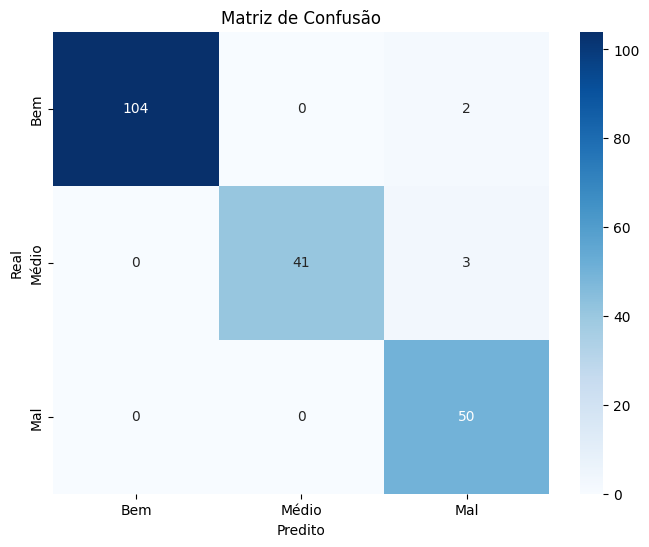

In [11]:
# Calcule a matriz de confusão
# Transformar as previsões de volta para as classes originais
y_pred_classes = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_classes = label_encoder.inverse_transform(np.argmax(y_test, axis=1))


cm = confusion_matrix(y_test_classes, y_pred_classes)  # Substitua y_test e y_pred pelos seus dados reais e previstos

# Crie uma visualização da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bem', 'Médio', 'Mal'], yticklabels=['Bem', 'Médio', 'Mal'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## Métricas de eficácia

In [14]:
print("----------------------------------------------------------------")
accuracy = accuracy_score(y_test_classes, y_pred_classes)  
print(f'Acurácia do Teste: {accuracy}')

print("----------------------------------------------------------------\n")
classification_rep = classification_report(y_test_classes, y_pred_classes)
print(f'Relatório de Classificação:\n{classification_rep}')


# precision = precision_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Precisão: {precision}')

# recall = recall_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Recall: {recall}')

# f1 = f1_score(y_test, y_pred)  # Substitua y_test e y_pred pelos seus dados reais e previstos
# print(f'Medida F: {f1}')

----------------------------------------------------------------
Acurácia do Teste: 0.975
----------------------------------------------------------------

Relatório de Classificação:
              precision    recall  f1-score   support

         Bem       1.00      0.98      0.99       106
         Mal       1.00      0.93      0.96        44
       Médio       0.91      1.00      0.95        50

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.98      0.97      0.98       200

